In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import os
import numpy as np

np.float64(95.99553092424617)

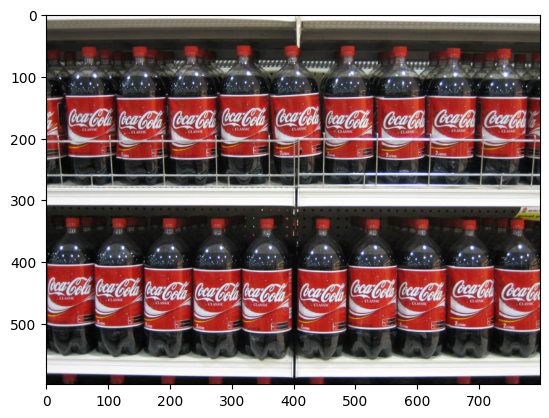

In [2]:
coca_multi = cv.cvtColor(cv.imread('images/coca_multi.png'), cv.COLOR_BGR2RGB)
plt.imshow(coca_multi)
np.mean(coca_multi)

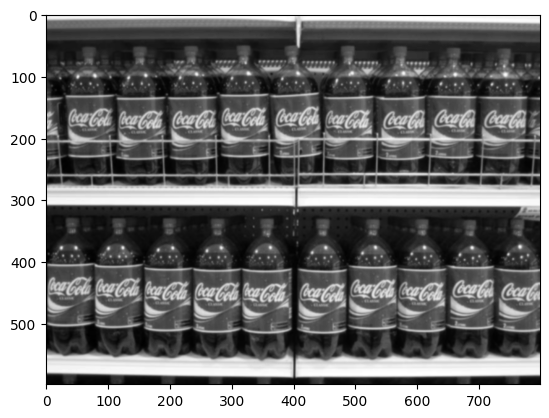

In [32]:
def filter_closed_loops(gray):
    _, binary = cv.threshold(gray, 127, 255, cv.THRESH_BINARY)
    contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(binary)
    for contour in contours:
        if not cv.isContourConvex(contour):
            if cv.arcLength(contour, cv.isContourConvex(contour)) > 100 and cv.contourArea(contour) > 20:
                cv.drawContours(mask, [contour], -1, 255, thickness=cv.FILLED)
    filtered_image = cv.bitwise_and(binary, mask)
    return filtered_image
    
def preprocess(image, kernel_size=5, threshold_1=100, threshold_2=200):
    grayscale = cv.cvtColor(image, cv.COLOR_RGB2GRAY) if len(image.shape) == 3 else image.copy()
    blurred = cv.GaussianBlur(grayscale, (kernel_size, kernel_size), 0)
    canny_edges = cv.Canny(blurred, threshold_1, threshold_2)
    canny_edges_after_blur = cv.Canny(blurred,threshold_1, threshold_2)
    kernel = np.ones((3, 3), np.uint8) 
    filtered = filter_closed_loops(canny_edges_after_blur)
    return grayscale, blurred, canny_edges, canny_edges_after_blur, filtered

def preprocess_(image, kernel_size=5, threshold_1=100, threshold_2=200):
    return preprocess(image, kernel_size, threshold_1, threshold_2)[4]

def preprocess_blur(image, kernel_size=5, threshold_1=100, threshold_2=200):
    return preprocess(image, kernel_size, threshold_1, threshold_2)[1]

grayscale, blurred, canny_edges, canny_edges_after_blur,filtered = preprocess(coca_multi, kernel_size=5)
plt.imshow(blurred, cmap='gray')

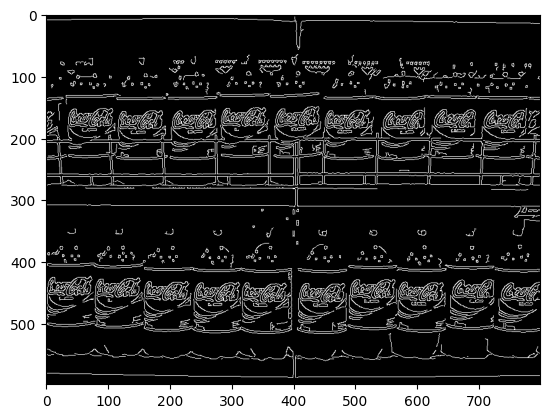

In [4]:
plt.imshow(canny_edges, cmap='gray')

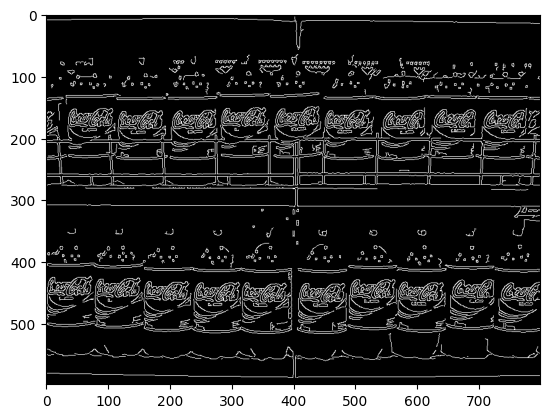

In [5]:
plt.imshow(canny_edges_after_blur, cmap='gray')

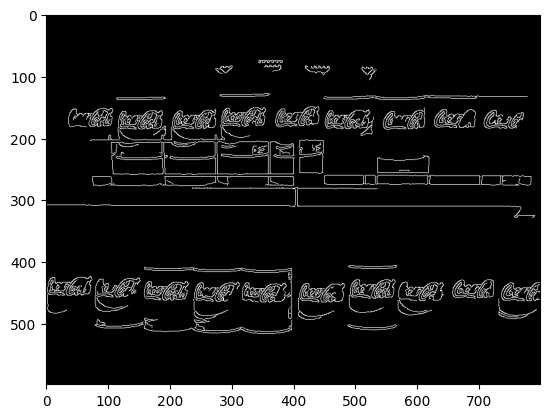

In [6]:
plt.imshow(filtered, cmap='gray')

2.9166666666666665

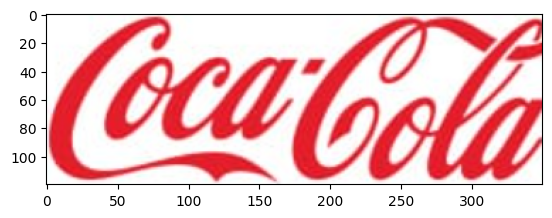

In [7]:
template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)
template_reduced = template[30:-25, 10:-40]
plt.imshow(template_reduced)
aspect_ratio = template_reduced.shape[1]/template_reduced.shape[0]
aspect_ratio

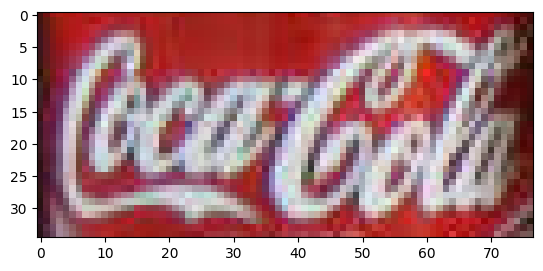

In [8]:
some_other = coca_multi.copy()
some_other = some_other[150:185,33:110,:]
plt.imshow(some_other)

In [9]:
some_other.shape

(35, 77, 3)

In [10]:
aspect_ratio = some_other.shape[1]/some_other.shape[0]
aspect_ratio

2.2

In [ ]:
import imutils
def get_templates():
    templates = []   
    template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)
    edged_template = preprocess_(template)
    for scale in np.linspace(0.2,10,20):
            resized = imutils.resize(edged_template, width=int(edged_template.shape[1] * scale))
            for scale_w in np.linspace(0.5,1,5):
                h,w = resized.shape[:2]
                new_resized = cv.resize(resized, (int(w*scale_w),h))
                templates.append(new_resized)
    return templates
                

all_templates = get_templates()


In [33]:
import imutils
import numpy as np
def normalize(x, xmax, xmin):
    return (x - xmin) / (xmax - xmin)

def detect_logo(image_rgb, method, threshold=0.80):
    template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)
    # template_reduced = template[30:-25, 10:-15]
    # template_reduced = template[30:-25, 10:-40]
    edged_template = preprocess_(template)
    
    modified_image = image_rgb.copy()
    gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
    tW, tH = gray.shape[::-1]
    found = {}    
    min_result = 1e20
    max_result = -1e20
    all_results = np.array([], dtype=np.float32)

    edged = preprocess_(image_rgb)
    # plt.imshow(edged, cmap='gray')
    
    for scale in np.linspace(0.2,4,10):
        # resized = imutils.resize(edged_template, width=int(edged_template.shape[1] * scale))
        # for scale_w in np.linspace(0.5,1,5):
        #     h,w = resized.shape[:2]
        #     new_resized = cv.resize(resized, (int(w*scale_w),h))
        #     if new_resized.shape[0] <= 0.05 * image_rgb.shape[0] or new_resized.shape[1] <= 0.10*image_rgb.shape[1]:
        #         continue
        #     if new_resized.shape[0] > image_rgb.shape[0] or new_resized.shape[1] > image_rgb.shape[1]:
        #         continue
        #     try:
        #         result = cv.matchTemplate(edged, new_resized, method)
        #         found[f'{new_resized.shape[0]},{new_resized.shape[1]},{method}'] = result
        #         all_results = np.concatenate((all_results, result.flatten()))
        #         min_result = min(min_result, np.min(result))
        #         max_result = max(max_result, np.max(result))
        #     except Exception as e:
        #         pass
        resized = imutils.resize(edged_template, width=int(edged_template.shape[1] * scale))
        h,w = resized.shape[:2]
        new_resized = resized.copy()
        # new_resized = cv.resize(resized, (int(w*scale_w),h))
        # if new_resized.shape[0] <= 0.05 * image_rgb.shape[0] or new_resized.shape[1] <= 0.10*image_rgb.shape[1]:
        #     continue
        if new_resized.shape[0] > image_rgb.shape[0] or new_resized.shape[1] > image_rgb.shape[1]:
            continue
        try:
            result = cv.matchTemplate(edged, new_resized, method)
            found[f'{new_resized.shape[0]},{new_resized.shape[1]},{method}'] = result
            all_results = np.concatenate((all_results, result.flatten()))
            min_result = min(min_result, np.min(result))
            max_result = max(max_result, np.max(result))
        except Exception as e:
            pass

    

    # print(max_result)
    # print(min_result)
    bbox = []
    scores = []
    for scale_hash, result_scale in found.items():
        normalized_data = normalize(result_scale, max_result, min_result)
        loc = np.where(normalized_data >= threshold)
       
        h, w =[int(el) for el in scale_hash.split(',')[:2]]

        for pt in zip(*loc[::-1]):
            top_left = pt
            startX, startY = top_left[0], top_left[1]
            endX, endY = top_left[0]+w, top_left[1]+h
            cv.rectangle(modified_image, (startX, startY), (endX, endY), (0, 0, 255), 2)
            bbox.append([startX, startY, endX, endY])
            scores.append(normalized_data[top_left[1], top_left[0]])

    return bbox, scores, normalize(all_results, max_result, min_result), modified_image

bbox_multi, scores_multi, hist_data, modified_image = detect_logo(coca_multi, cv.TM_CCORR_NORMED, threshold=0.80)


[3.5959396e-01 3.5959396e-01 3.5959396e-01 ... 1.0652116e+06 1.4553611e+06
 4.1496166e+05]
[1.3617778e-01 1.5106866e-01 1.5862298e-01 ... 1.0118703e+06 1.3682311e+06
 8.1424588e+05]
[429988.4   39838.9  234913.66 ...      0.       -0.        0.  ]
[-1069920.9  -933441.1  -885994.5 ...  2563193.2  2875574.8  1692384.4]
[8.8421392e-01 8.1646717e-01 7.7531284e-01 ... 1.2663370e+06 1.4219208e+06
 2.1598930e+06]
[-319417.25   -59317.       5707.875 ... -200371.16  -110498.695
 -280726.28 ]
[-175783.9  -181643.6  -187503.   ... -603307.3  -893980.06 -924553.3 ]


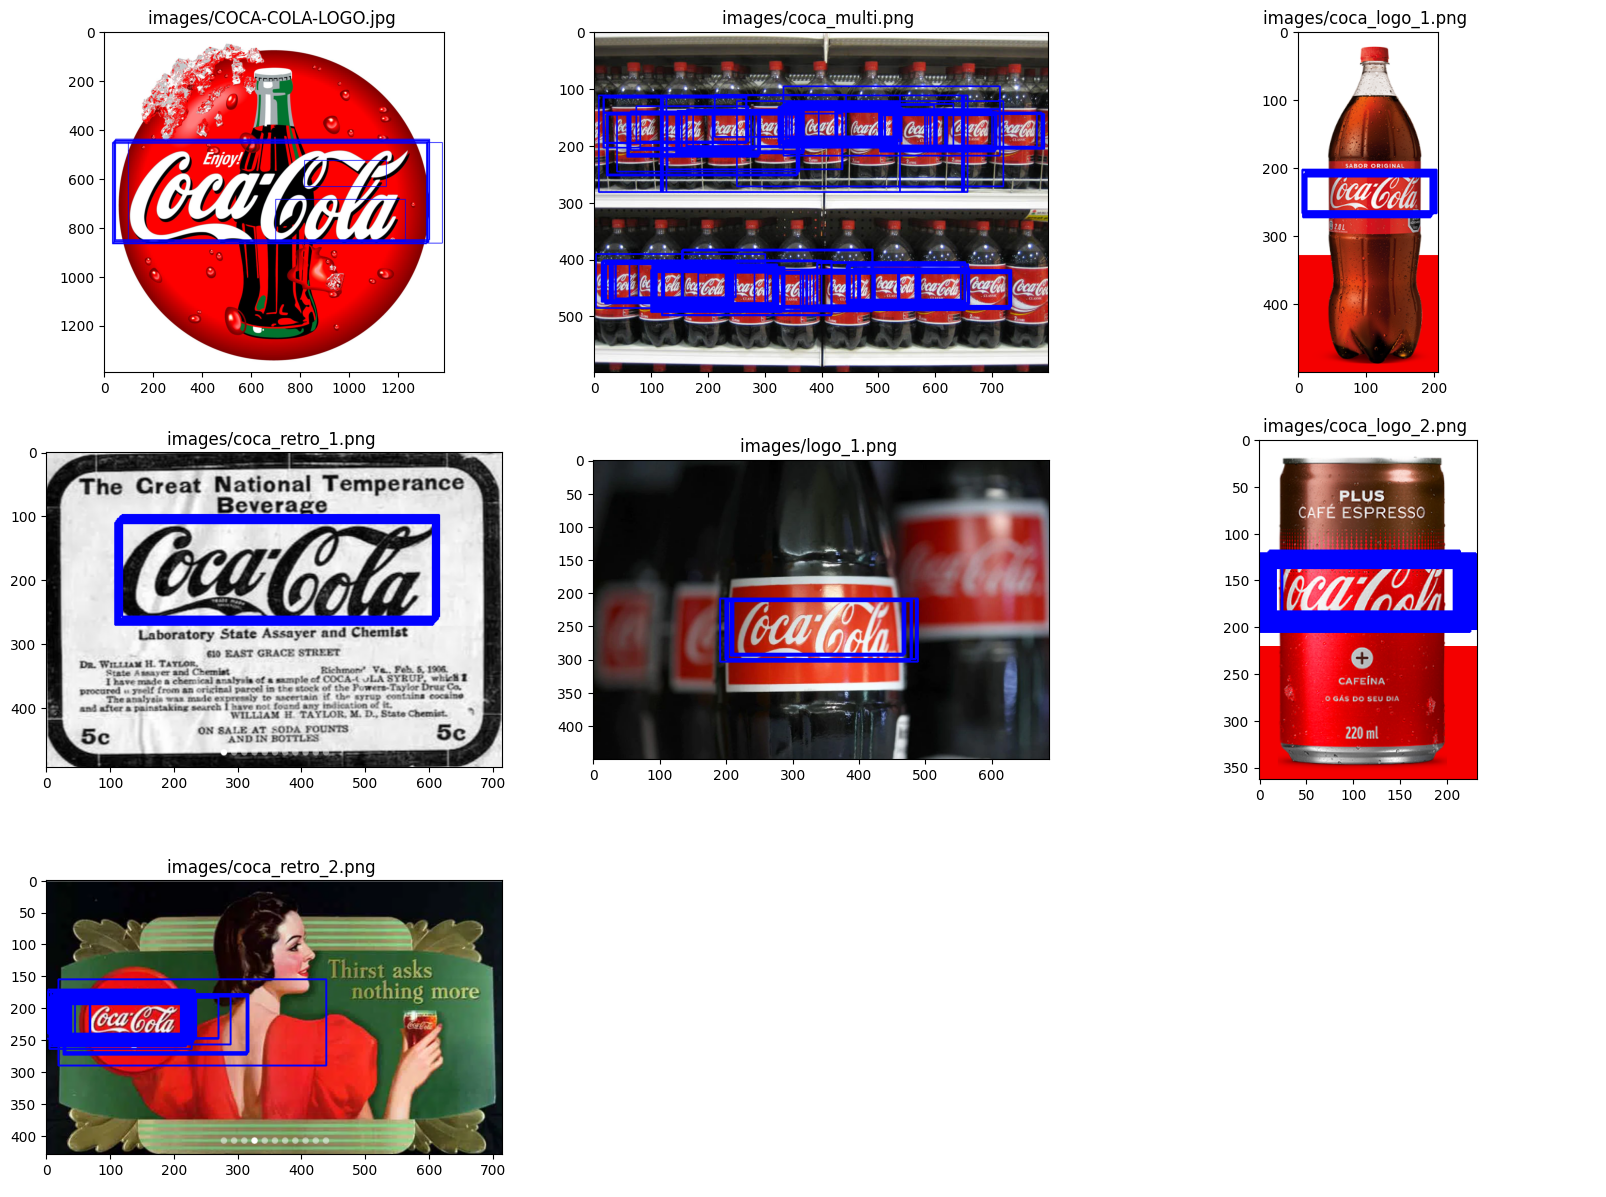

In [40]:
# esta es resizeando la img original
import imutils
import numpy as np

test_images = os.listdir('images')
test_images_paths = [f'images/{im}' for im in test_images]
test_images_color = [cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB) for path in test_images_paths]

def plot_images(img_list, img_names, method='', cols=3):
    rows = len(img_list)//cols + 1
    f, axes = plt.subplots(rows,cols, figsize=(20,15)) 
    axes = axes.flatten()
    
    for i,ax in enumerate(axes):
        if i < len(img_list):
            ax.imshow(img_list[i])
            ax.set_title(f'{img_names[i]} {method}')
        else:
            ax.axis('off')


def normalize(x, xmax, xmin):
    return (x - xmin) / (xmax - xmin)

def detect_logo(image_rgb, method, threshold=0.80):
    template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)
    template_reduced = template[30:-25, 10:-15]
    edged_template = preprocess_(template_reduced)
    
    modified_image = image_rgb.copy()
    gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
    tW, tH = edged_template.shape[::-1]
    found = {}    
    all_results = np.array([], dtype=np.float32)

    edged = preprocess_(image_rgb)
    # plt.imshow(edged, cmap='gray')
    
    for scale in np.linspace(0.2, 2.0, 40)[::-1]:
        # Resize the image according to the scale and keep track of the resizing ratio
        resized = imutils.resize(gray, width=int(gray.shape[1] * scale))
        r = gray.shape[1] / float(resized.shape[1])
        edged = preprocess_(resized)

        try:
            result = cv.matchTemplate(edged, edged_template, method)
            found[f'{resized.shape[0]},{resized.shape[1]},{r},{method}'] = result
            all_results = np.concatenate((all_results, result.flatten()))
        except Exception as e:
            # print('exception', e)
            pass
    print(all_results)
    min_result = np.min(all_results)
    max_result = np.max(all_results)
    
    bbox = []
    scores = []
    for scale_hash, result_scale in found.items():
        normalized_data = normalize(result_scale, max_result, min_result)
        loc = np.where(normalized_data >= threshold)
        r = float(scale_hash.split(',')[2])

        for pt in zip(*loc[::-1]):
            top_left = pt
            startX, startY = int(top_left[0]*r), int(top_left[1]*r)
            endX, endY = int((top_left[0]+tW)*r), int((top_left[1]+tH)*r)
            cv.rectangle(modified_image, (startX, startY), (endX, endY), (0, 0, 255), 2)
            bbox.append([startX, startY, endX, endY])
            scores.append(normalized_data[top_left[1], top_left[0]])

    return bbox, scores, normalize(all_results, max_result, min_result), modified_image

# bbox_multi, scores_multi, hist_data, modified_image = detect_logo(coca_multi, cv.TM_CCORR_NORMED, threshold=0.80)
plot_images([detect_logo(img, cv.TM_CCOEFF)[3] for img in test_images_color], test_images_paths)

In [ ]:
def get_template():
    template_gray = cv.imread('template/pattern.png', cv.IMREAD_GRAYSCALE)
    template_gray_canny = cv.Canny(template_gray, 100,200)
    template_canny_reduced = template_gray_canny[30:-25, 10:-15]
    return template_canny_reduced
    
def detect_logo(image_rgb, method):
    template = get_template()
    tW, tH = template.shape[::-1]
    modified_image = image_rgb.copy()
    gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)

    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        found = (1e20, [], 0)
    else:
        found = (-1e20, [], 0)
    # Loop over the scales of the image
    for scale in np.linspace(0.2, 2.0, 40)[::-1]:
        # Resize the image according to the scale and keep track of the resizing ratio
        resized = imutils.resize(gray, width=int(gray.shape[1] * scale))
        r = gray.shape[1] / float(resized.shape[1])

        try:

            # Detect edges in the resized, grayscale image and apply template matching
            edged = cv.Canny(resized, 100, 200)
            result = cv.matchTemplate(edged, template, method)
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)
    
            # Determine the top-left corner of the match based on the method
            if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                value, top_left = min_val, min_loc
                if value < found[0]:
                    found = (value, top_left, r)
                
            else:
                value, top_left = max_val, max_loc
                if value > found[0]:
                    found = (value, top_left, r)
    
        except Exception as e:
            pass

    # Unpack the bookkeeping variable and compute the bounding box
    if found is not None:
        _, top_left, r = found
        startX, startY = int(top_left[0] * r), int(top_left[1] * r)
        endX, endY = int((top_left[0] + tW) * r), int((top_left[1] + tH) * r)

        # Draw a bounding box around the detected result
        cv.rectangle(modified_image, (startX, startY), (endX, endY), (0, 0, 255), 2)

    return modified_image

    
methods = ['TM_CCOEFF', 'TM_CCOEFF_NORMED', 'TM_CCORR',
            'TM_CCORR_NORMED', 'TM_SQDIFF', 'TM_SQDIFF_NORMED']
cv_methods = [cv.TM_CCOEFF, cv.TM_CCOEFF_NORMED, cv.TM_CCORR, cv.TM_CCORR_NORMED, cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED ]

for method, cv_method in zip(methods, cv_methods): 
    detections = [detect_logo(test_img, cv_method) for test_img in test_images_color]
    plot_images(detections, test_images, method)

In [ ]:
_ = plt.hist(hist_data, bins=200, range=(0.8,1))

In [ ]:
plt.imshow(modified_image)

In [ ]:
# Apply non-maximum suppression
coca_multi_copy = coca_multi.copy()
indices = cv.dnn.NMSBoxes(bboxes=bbox_multi, scores=scores_multi, score_threshold=0.82, nms_threshold=0.90, eta=0.99)
# Filter out the boxes based on the NMS result
filtered_boxes = [bbox_multi[i] for i in indices.flatten()]
filtered_scores = [scores_multi[i] for i in indices.flatten()]
# Draw the filtered boxes on the image
for (xmin, ymin, xmax, ymax), score in zip(filtered_boxes, filtered_scores):
    cv.rectangle(coca_multi_copy, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
    text = f"{score:.2f}"
    cv.putText(
        coca_multi_copy, 
        text, 
        (xmin, ymin - 10),  # Position text slightly above the top-left corner of the box
        cv.FONT_HERSHEY_SIMPLEX, 
        0.5,  # Font size
        (0, 255, 0),  # Font color (same as the box)
        2,  # Thickness
        cv.LINE_AA
    )
plt.imshow(coca_multi_copy)

In [ ]:
test_images = os.listdir('images')
test_images_paths = [f'images/{im}' for im in test_images]
test_images_color = [cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB) for path in [test_images_paths[0]]]


bbox_multi, scores_multi, hist_data, modified_image = detect_logo(test_images_color[0], cv.TM_CCORR_NORMED, threshold=0.70)

In [ ]:
_ = plt.hist(hist_data, bins=200, range=(0.8,1))

In [ ]:
plt.imshow(modified_image)

In [ ]:
# Apply non-maximum suppression
coca_multi_copy = test_images_color[0].copy()
indices = cv.dnn.NMSBoxes(bboxes=bbox_multi, scores=scores_multi, score_threshold=0.5, nms_threshold=0.99, eta=0.99)
# Filter out the boxes based on the NMS result
filtered_boxes = [bbox_multi[i] for i in indices.flatten()]
filtered_scores = [scores_multi[i] for i in indices.flatten()]
# Draw the filtered boxes on the image
for (xmin, ymin, xmax, ymax), score in zip(filtered_boxes, filtered_scores):
    cv.rectangle(coca_multi_copy, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
    text = f"{score:.2f}"
    cv.putText(
        coca_multi_copy, 
        text, 
        (xmin, ymin - 10),  # Position text slightly above the top-left corner of the box
        cv.FONT_HERSHEY_SIMPLEX, 
        0.5,  # Font size
        (0, 255, 0),  # Font color (same as the box)
        2,  # Thickness
        cv.LINE_AA
    )
plt.imshow(coca_multi_copy)

In [ ]:
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
img1 = cv.bitwise_not(cv.cvtColor(template.copy(), cv.COLOR_BGR2GRAY))
img2 = cv.cvtColor(test_images_color[0].copy(),cv.COLOR_BGR2GRAY)
# template.copy()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
# good = matches
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(16, 16))
plt.title('SIFT Interest Points')
plt.imshow(img3)
plt.show()

In [ ]:
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
img1 = cv.bitwise_not(cv.cvtColor(template.copy(), cv.COLOR_BGR2GRAY))
img2 = cv.cvtColor(coca_multi.copy(),cv.COLOR_BGR2GRAY)
# template.copy()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# # BFMatcher with default params
# # bf = cv.BFMatcher()
# bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# # matches = bf.knnMatch(des1,des2,k=2)
# matches = bf.knnMatch(des1,des2,k=2)
# # Apply ratio test
# # good = matches
# # Sort them in the order of their distance.
# matches = sorted(matches, key = lambda x:x.distance)
# # good = []
# # for m,n in matches:
# #     if m.distance < 0.7*n.distance:
# #         good.append([m])
# # cv.drawMatchesKnn expects list of lists as matches.
# img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# plt.figure(figsize=(16, 16))
# plt.title('SIFT Interest Points')
# plt.imshow(img3)
# plt.show()

# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
 
# Match descriptors.
matches = bf.match(des1,des2)
 
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
 
# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
 
plt.imshow(img3),plt.show()



In [ ]:
test_images = os.listdir('images')
test_images_paths = [f'images/{im}' for im in test_images]
test_images_color = [cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB) for path in test_images_paths]

In [ ]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Load and process images
test_images = os.listdir('images')
test_images_paths = [f'images/{im}' for im in test_images]
test_images_color = [cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB) for path in test_images_paths]
preprocessed_images_gray = [preprocess_blur(el) for el in test_images_color]

# Function to compute and plot the power spectrum
def plot_centered_power_spectrum(image, title="Power Spectrum"):
    # Convert to grayscale for FFT
    if len(image.shape) == 2:
        gray_image = image.copy()
    else:
        gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    
    # Compute FFT and shift the zero frequency to the center
    fft_image = np.fft.fft2(gray_image)
    fft_shift = np.fft.fftshift(fft_image)
    
    # Compute the magnitude spectrum and apply logarithmic scaling
    power_spectrum = np.abs(fft_shift)**2
    log_magnitude_spectrum = 1 + np.log(power_spectrum)
    
    # Plot the power spectrum
    plt.figure(figsize=(6, 6))
    plt.imshow(log_magnitude_spectrum, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot the power spectrum for each image
for i, image in enumerate(preprocessed_images_gray):
    plot_centered_power_spectrum(image, title=f"Power Spectrum of Image {i + 1}")


In [ ]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Load and process images
test_images = os.listdir('images')
test_images_paths = [f'images/{im}' for im in test_images]
test_images_color = [cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB) for path in test_images_paths]
# preprocessed_images_gray = [preprocess(el)[4] for el in test_images_color]
preprocessed_images_gray = test_images_color.copy()

# Function to compute and plot the power spectrum
def plot_centered_power_spectrum(image, title="Power Spectrum"):
    # Convert to grayscale for FFT
    if len(image.shape) == 2:
        gray_image = image.copy()
    else:
        gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    
    # Compute FFT and shift the zero frequency to the center
    fft_image = np.fft.fft2(gray_image)
    fft_shift = np.fft.fftshift(fft_image)
    
    # Compute the magnitude spectrum and apply logarithmic scaling
    power_spectrum = np.abs(fft_shift)**2
    log_magnitude_spectrum = 1 + np.log(power_spectrum)
    
    # Plot the power spectrum
    plt.figure(figsize=(6, 6))
    plt.imshow(log_magnitude_spectrum, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot the power spectrum for each image
for i, image in enumerate(preprocessed_images_gray):
    plot_centered_power_spectrum(image, title=f"Power Spectrum of Image {i + 1}")


In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def spatial_frequency_metric(image):
    # Convert to grayscale
    if len(image.shape) == 2:
        gray_image = image.copy()
    else:
        gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    
    # Compute FFT and shift the zero frequency to the center
    fft_image = np.fft.fft2(gray_image)
    fft_shift = np.fft.fftshift(fft_image)
    
    # Compute the magnitude spectrum
    # magnitude_spectrum = np.abs(fft_shift)
    power_spectrum = np.abs(fft_shift)**2
    
    # Create coordinate grid for weighting by spatial frequency
    rows, cols = power_spectrum.shape  # Ensure exact shape
    crow, ccol = rows // 2, cols // 2
    x = np.linspace(-ccol, ccol - 1, cols)
    y = np.linspace(-crow, crow - 1, rows)
    X, Y = np.meshgrid(x, y)
    distance = np.sqrt(X**2 + Y**2)  # Distance from the center (frequency magnitude)
    
    # Compute weighted spatial frequency metric
    weighted_sum = np.sum(power_spectrum * distance)
    return weighted_sum


# Compute spatial frequency metrics for all images
metrics = [spatial_frequency_metric(image) for image in preprocessed_images_gray]

for metric in metrics:
    print(metric)
# print(metrics)
# Sort images by spatial frequency metric
sorted_indices = np.argsort(metrics)  # Sort in ascending order
filtered_indices = sorted_indices[-3:]  # Keep indices of images with the highest spatial frequency

# Plot filtered images
for i in filtered_indices:
    plt.figure(figsize=(6, 6))
    plt.imshow(test_images_color[i])
    plt.title(f"Image {i + 1} with High Spatial Frequency")
    plt.axis('off')
    plt.show()

In [ ]:
def filter_high_frequency_images_spatial(image, pixel_threshold=50, energy_threshold=0.05):
    # Convert to grayscale if necessary
    if len(image.shape) == 2:
        gray_image = image.copy()
    else:
        gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    
    # Compute FFT and shift the zero frequency to the center
    fft_image = np.fft.fft2(gray_image)
    fft_shift = np.fft.fftshift(fft_image)
    
    # Compute the power spectrum
    power_spectrum = np.abs(fft_shift)**2
    
    # Image dimensions
    rows, cols = power_spectrum.shape
    crow, ccol = rows // 2, cols // 2
    max_dim = max(rows, cols)
    
    # Convert pixel threshold to frequency threshold
    freq_threshold = 1 / pixel_threshold
    freq_index_threshold = freq_threshold * max_dim
    
    # Create coordinate grid for distances
    x = np.linspace(-ccol, ccol - 1, cols)
    y = np.linspace(-crow, crow - 1, rows)
    X, Y = np.meshgrid(x, y)
    distance = np.sqrt(X**2 + Y**2)  # Distance from the center in FFT indices
    
    # Mask for high-frequency components (> threshold)
    high_freq_mask = distance > freq_index_threshold
    
    # Compute energy in high-frequency components
    high_freq_energy = np.sum(power_spectrum[high_freq_mask])
    total_energy = np.sum(power_spectrum)
    high_freq_ratio = high_freq_energy / total_energy
    # print('high_freq_ratio:', high_freq_ratio)
    
    # Check if the high-frequency ratio exceeds the threshold
    return high_freq_ratio

# Apply filtering to all images
pixel_threshold = 50  # Corresponding spatial frequency threshold
energy_threshold = 0.00001  # Fraction of energy to consider as high

preprocessed_images_gray = [preprocess(el)[4] for el in test_images_color]
# preprocessed_images_gray = test_images_color.copy()

high_freq_ratios = [
    filter_high_frequency_images_spatial(image, pixel_threshold, energy_threshold)
    for image in preprocessed_images_gray
]

# print(high_freq_ratios)

# Filter indices based on the energy threshold and sort by high-frequency ratio
filtered_indices_with_ratios = [
    (i, ratio) for i, ratio in enumerate(high_freq_ratios) if ratio > energy_threshold
]

# Sort by high-frequency ratio in descending order
sorted_filtered_indices = sorted(filtered_indices_with_ratios, key=lambda x: x[1], reverse=True)

# Plot images sorted by high-frequency content
for i, ratio in sorted_filtered_indices:
    plt.figure(figsize=(6, 6))
    plt.imshow(test_images_color[i])
    plt.title(f"Filtered Image {i + 1} (High Freq Ratio: {ratio:.4f})")
    plt.axis('off')
    plt.show()

In [ ]:
detections = []
for i,image in enumerate(test_images_color):
    print(f"iterating {i}")
    # is_high_spatial_freq_image = filter_high_frequency_images_spatial(image, pixel_threshold, energy_threshold) > 0.08
    # if is_high_spatial_freq_image:
        # _,_,_,im_w_detections = detect_logo(image, cv.TM_CCORR_NORMED, 0.8)
    # else:
        # _,_,_,im_w_detections = detect_logo(image, cv.TM_CCOEFF, 0.99)
    _,_,_,im_w_detections = detect_logo(image, cv.TM_CCOEFF, 0.8)
    detections.append(im_w_detections)



def plot_images(img_list, img_names, method='', cols=3):
    rows = len(img_list)//cols + 1
    f, axes = plt.subplots(rows,cols, figsize=(20,15)) 
    axes = axes.flatten()
    
    for i,ax in enumerate(axes):
        if i < len(img_list):
            ax.imshow(img_list[i])
            ax.set_title(f'{img_names[i]} {method}')
        else:
            ax.axis('off')

plot_images(detections, test_images_paths)